# Developer Survey Analysis

The goal is this analysis is to analyze the 2018 survey results and gain relevant insights pertaining to the profession. Some questions we are interested in right off the bat are:
- what are the most popular languages/technologies among developers? Among data scientist in general?
- what are the determinants of job satisfaction?
- is it possible to extract different data scientist "archetypes" from this survey? Do they differ from developers as a broader group?

We will leverage descriptive statistics as well as modeling to answer all these questions. We will analyze the results collected by Stack Overflow and made publicly available [here](https://insights.stackoverflow.com/survey).

In [49]:
# We start by loading the necessary libraries
import pandas as pd
import numpy as np
import matplotlib as plt
import zipfile
import os
import re

%matplotlib inline

## Loading the Data

In [2]:
# We first extract the file from its archive and then ingest it into Pandas

zip_ref = zipfile.ZipFile('developer_survey_2018.zip', 'r')
zip_ref.extractall(os.getcwd())
zip_ref.close()

data_2018 = pd.read_csv('survey_results_public.csv')
schema_2018 = pd.read_csv('survey_results_schema.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Initial Assessment

In [3]:
print('The 2018 survey results have {} respondents and {} variables'.format(str(data_2018.shape[0]),
                            str(data_2018.shape[1])))

The 2018 survey results have 98855 respondents and 129 variables


In [4]:
# The schema will serve as a useful guide
schema_2018.head()

,Column,QuestionText
0,Respondent,Randomized respondent ID number (not in order ...
1,Hobby,Do you code as a hobby?
2,OpenSource,Do you contribute to open source projects?
3,Country,In which country do you currently reside?
4,Student,"Are you currently enrolled in a formal, degree..."


In [56]:
# We can print out the data type of each column, since it will inform our analysis
data_2018.dtypes

Respondent                       int64
Hobby                           object
OpenSource                      object
Country                         object
Student                         object
Employment                      object
FormalEducation                 object
UndergradMajor                  object
CompanySize                     object
DevType                         object
YearsCoding                     object
YearsCodingProf                 object
JobSatisfaction                 object
CareerSatisfaction              object
HopeFiveYears                   object
JobSearchStatus                 object
LastNewJob                      object
AssessJob1                     float64
AssessJob2                     float64
AssessJob3                     float64
AssessJob4                     float64
AssessJob5                     float64
AssessJob6                     float64
AssessJob7                     float64
AssessJob8                     float64
AssessJob9               

The 2018 survey gathered responses from almost 100,000 people, on 129 questions. It will be really useful to answer the questions at hand. We have both numeric and categorical variables, which we will need to encode in order to be able to plug them in machine learning models.

## Data Preparation

### Missing Values

We assess the presence of missing values, and deal with them.

In [6]:
# We assess the columns
data_2018.isnull().mean().sort_values(ascending = False)

TimeAfterBootcamp              0.932710
MilitaryUS                     0.840362
HackathonReasons               0.740114
ErgonomicDevices               0.655475
AdBlockerReasons               0.618178
StackOverflowJobsRecommend     0.612392
JobEmailPriorities1            0.532517
JobEmailPriorities2            0.532517
JobEmailPriorities3            0.532517
JobEmailPriorities4            0.532517
JobEmailPriorities6            0.532517
JobEmailPriorities5            0.532517
JobEmailPriorities7            0.532517
ConvertedSalary                0.517455
JobContactPriorities3          0.507299
JobContactPriorities4          0.507299
JobContactPriorities2          0.507299
JobContactPriorities1          0.507299
JobContactPriorities5          0.507299
Salary                         0.488362
SalaryType                     0.483385
FrameworkWorkedWith            0.477821
TimeFullyProductive            0.475272
AdBlockerDisable               0.444661
FrameworkDesireNextYear        0.441424


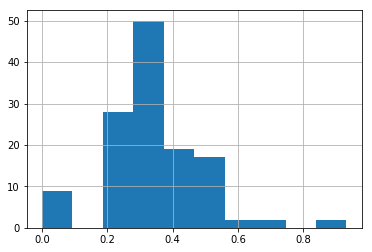

In [7]:
data_2018.isnull().mean(axis = 0).hist();

In [8]:
# We drop the columns with more than 60% of missing values
data_2018 = data_2018.loc[:, data_2018.isnull().mean() < 0.6]

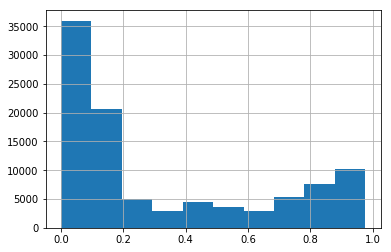

In [9]:
# We now assess the rows
data_2018.isnull().mean(axis = 1).hist();

In [10]:
# We drop the rows with more than 80% of missing values
data_2018 = data_2018.loc[data_2018.isnull().mean(axis = 1) < 0.8,:]

In [11]:
print('After removing missing values, the 2018 survey results have {} respondents and {} variables'.format(str(data_2018.shape[0]),
                            str(data_2018.shape[1])))

After removing missing values, the 2018 survey results have 82184 respondents and 123 variables


We assess missing values in rows and columns. We remove columns which have more than 50% of missing values, as well as rows that have more than 80% of missing values, for both these groups do not provide us with useful information for our purposes. We are still left with 123 variables and 82,184 respondents. We will probably have to impute or do more cleaning later on, but this is a good first pass for now.

### Duplicate Values

In [12]:
print(data_2018.Respondent.duplicated().sum(), data_2018.duplicated().sum())

0 0


No duplicate values to deal with. 

### Categorical Variables

In [66]:
# We transform the salary variable from a categorical to a numerical variables
data_2018.Salary = data_2018.Salary.str.replace(',', '')
data_2018.Salary = data_2018.Salary.astype(int)

AttributeError: Can only use .str accessor with string values, which use np.object_ dtype in pandas

In [67]:
categorical_cols = data_2018.select_dtypes(include = ["object"]).columns.values.tolist()
data_2018_dummies = pd.get_dummies(data_2018, columns = categorical_cols, dummy_na = True)

In [68]:
# We drop columns which arise from the multiple response nature of the survey, only keeping the most general answer
cols = []

for c in data_2018_dummies.columns:
    if (re.search(r'.*;.*', c)):
        cols.append(c)

data_2018_dummies.drop(cols, axis =1, inplace = True)

We use one-hot encoding for categorical variables, which will enable us to use them in machine learning models later on. Before doing so, we have to convert the salary variable to numeric (it was viewed as categorical due to the thousand separator certain respondents used). Due to the way certain responses were recorded, we also choose to remove detailed descriptions, only keeping the uppermost level.

### Languages and Frameworks

Look overall, and whether there are associations/biases within various groups/professions. Consider using the original dataset vs. the dummy one for this. Focus on the differences between DS and developers.

### Determinants of job satisfaction

Linear Regression model. Impute missing values. 

### Archetypes

Subset only a few variables of interest (salary, education, languages used, big/small company, job satisfaction, experience) Drill in within the data scientist profession in the US, and repeat the analysis for developers, comparing the two. 